In [10]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import pandas as pd
import itertools
import matplotlib.pyplot as plt
import numpy as np
import random
import os
import tensorflow as tf
from IPython.display import clear_output
import time

In [11]:
def nash_sutcliffe(obs, sim):
    return 1 - np.sum((obs - sim) ** 2) / np.sum((obs - np.mean(obs)) ** 2)

def PERS(obs, sim):
    shifted = np.roll(obs, -1)
    obs_1 = np.delete(shifted,len(shifted)-1)
    obs_0 = np.delete(obs, len(obs)-1)
    return 1 - np.sum((obs - sim) ** 2) / np.sum((obs_0 - obs_1) ** 2)

In [12]:
#Chargement des données (remplace ceci par ton propre chargement)
df_x = pd.read_csv(r"C:\Users\bricaud\PycharmProjects\Bibliographie_\Adaptation\3-Adaptation MLP\Results [Full]\data_full_Alsace_['P_', 'T_', 'ETP_', 'RAD_']_10000.txt", sep=';')
df_y = pd.read_csv(r"C:\Users\bricaud\PycharmProjects\Bibliographie_\Adaptation\2-Adaptation\adapt_Alsace.txt", sep=";")

In [13]:
#Adaptation des tailles entre x et y
len_x, len_y = len(df_x), len(df_y)
len_min = min(len_x, len_y)
x = df_x.iloc[::-1].iloc[:len_min]
y = df_y["Q_Obs"].iloc[:len_min]

In [14]:
#Séparer train/test
x_train, x_valid, y_train, y_valid = train_test_split(x, y, test_size=0.2, shuffle=False)
#Normalisation
x_scaler = StandardScaler()
y_scaler = StandardScaler()
x_isol_scaler = StandardScaler()
y_isol_scaler = StandardScaler()

x_train_scaled = x_scaler.fit_transform(x_train)
x_valid_scaled = x_scaler.transform(x_valid)

y_train_scaled = y_scaler.fit_transform(y_train.values.reshape(-1, 1))
y_valid_scaled = y_scaler.transform(y_valid.values.reshape(-1, 1))

len_before, len_after = int(730), int(730)
len_valid = len(x_valid)
x_valid_isol = x_valid.iloc[len_before:len_valid,:]
y_valid_isol = y_valid.iloc[len_before:len_valid]

x_train_scaled = x_isol_scaler.fit_transform(x_train)
x_valid_isol_scaled = x_isol_scaler.transform(x_valid_isol)

y_train_scaled = y_isol_scaler.fit_transform(y_train.values.reshape(-1, 1))
y_valid_isol_scaled = y_isol_scaler.transform(y_valid_isol.values.reshape(-1, 1))

In [15]:
df = pd.read_csv(r'C:\Users\bricaud\PycharmProjects\Bibliographie_\MLP\SEED.csv', header=None)
random_SEED = df.values.flatten().tolist()

In [16]:
A = [256,256,256,256,64]

In [17]:
 # t1 = time.time()
        # print(f"Step 1 - Reading CSV: {t1 - t0:.4f} seconds")

In [18]:
df_seed = pd.DataFrame()
df_stat = pd.DataFrame()
for i in range(len(random_SEED)) :
    print(i)
    len_a = len(A)
    SEED = random_SEED[i]
    os.environ['PYTHONHASHSEED'] = str(SEED)
    random.seed(SEED)
    np.random.seed(SEED)
    tf.random.set_seed(SEED)
    model = Sequential()
    for j in range(len_a) :
        model.add(Dense(int(A[j]), activation='relu'))
        # model.add(Dropout(0.2))
    model.add(Dense(1))  # Sortie régression
    model.compile(optimizer='adam', loss='mse', metrics=['mae', 'mape'])
    early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
    history = model.fit(x_train_scaled, y_train_scaled,
                        shuffle = True,
                        validation_split=0.2,
                        epochs=100,
                        batch_size=64,
                        callbacks=[early_stop],
                        verbose=0)

    loss, mae, mape = model.evaluate(x_valid_isol_scaled, y_valid_isol_scaled, verbose = 0)

    y_pred_scaled = model.predict(x_valid_isol_scaled, verbose = 0)
    y_pred = y_scaler.inverse_transform(y_pred_scaled)
    y_pred_flat = y_pred.flatten()

    df_stat[f"Seed :{SEED}"] = y_pred_flat

    nash = nash_sutcliffe(y_valid_isol.values, y_pred_flat)
    pers = PERS(y_valid_isol.values, y_pred_flat)

    df_seed.loc[i, "SEED"] = SEED
    df_seed.loc[i, "NSE"] = nash
    df_seed.loc[i, "PERS"] = pers
    df_seed.loc[i, "loss"] = loss
    df_seed.loc[i, 'mae'] = mae
    clear_output()

In [19]:
df_seed

,SEED,NSE,PERS,loss,mae
0,589.0,-0.430485,-72.178103,1.441724,1.071739
1,519.0,-0.046135,-52.516261,1.054353,0.898880
2,436.0,0.003744,-49.964606,1.004082,0.878622
3,773.0,-0.112605,-55.916590,1.121347,0.941922
4,134.0,-0.386766,-69.941625,1.397661,1.062872
5,729.0,-0.504475,-75.963123,1.516293,1.109300
6,358.0,-0.575783,-79.610981,1.588161,1.119033
7,489.0,-0.178927,-59.309382,1.188189,0.964905
8,369.0,-0.237972,-62.329855,1.247697,1.001500
9,124.0,-0.142113,-57.426124,1.151087,0.947502


In [20]:
row_stats = df_stat.T.describe().T
row_stats

,count,mean,std,min,25%,50%,75%,max
0,50.0,181.520203,0.047845,181.394928,181.494122,181.515396,181.558823,181.603714
1,50.0,181.514938,0.042409,181.392349,181.487221,181.512924,181.536079,181.630829
2,50.0,181.500229,0.047911,181.392090,181.468754,181.496857,181.539249,181.580704
3,50.0,181.500580,0.047465,181.393600,181.476406,181.491470,181.526379,181.654816
4,50.0,181.483002,0.051567,181.347336,181.455315,181.482887,181.510372,181.655121
...,...,...,...,...,...,...,...,...
1265,50.0,181.532669,0.052656,181.414993,181.490231,181.526566,181.568512,181.697678
1266,50.0,181.537537,0.050028,181.425552,181.498928,181.530327,181.567177,181.672958
1267,50.0,181.541626,0.049692,181.437134,181.503044,181.542831,181.571655,181.652298
1268,50.0,181.542572,0.050188,181.435074,181.512310,181.543076,181.577038,181.662216


error_sup (%): 6.8504, mean distance (m) 0.08662623613730211
error_inf (%): 77.6378, mean distance (m) 0.1624472262554667
close_valid (%): 3.6220
extended_valid (%): 11.8898


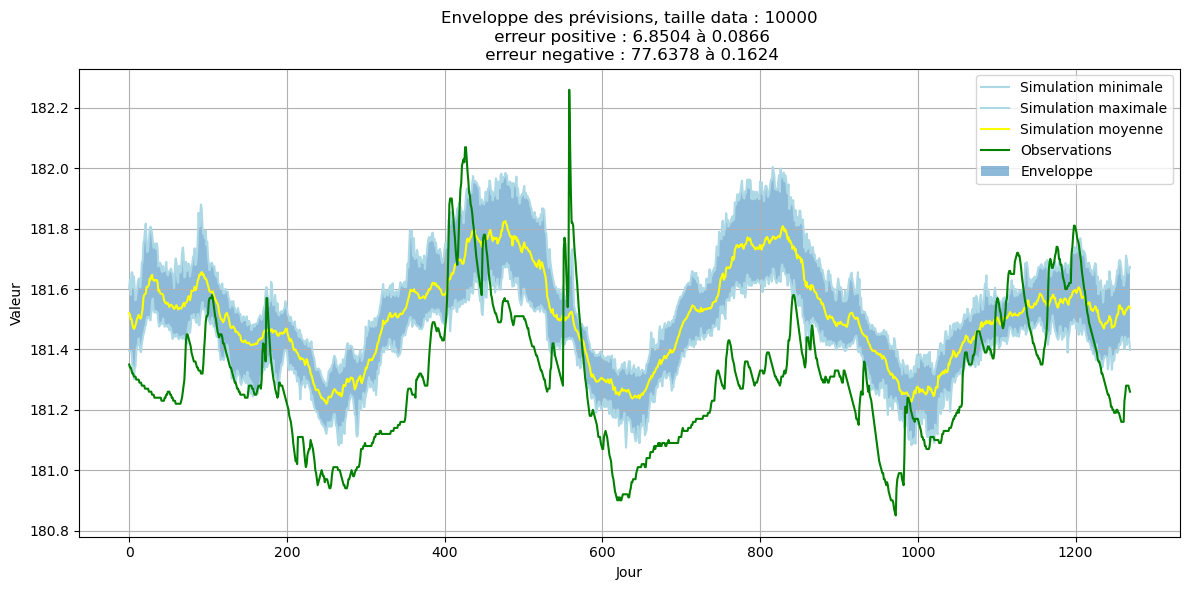

In [21]:
dif_plus = 0
P = []
dif_minus = 0
M = []
centered = 0
excentered = 0

for i in range(len(row_stats)):
    if y_valid_isol.iloc[i] > row_stats.loc[i, 'max']:
        dif_plus += 1
        P.append(y_valid_isol.iloc[i] - row_stats.loc[i, 'max'])
    elif y_valid_isol.iloc[i] < row_stats.loc[i, 'min']:
        dif_minus += 1
        M.append(row_stats.loc[i, 'min'] - y_valid_isol.iloc[i])
    elif row_stats.loc[i, '75%'] > y_valid_isol.iloc[i] > row_stats.loc[i, '25%']:
        centered += 1
    else:
        excentered += 1

error_sup = dif_plus / len(row_stats)
error_inf = dif_minus / len(row_stats)
close_valid = centered / len(row_stats)
extended_valid = excentered / len(row_stats)
mean_P = np.mean(P)
mean_M = np.mean(M)

print(f"error_sup (%): {error_sup * 100:.4f}, mean distance (m) {mean_P}")
print(f"error_inf (%): {error_inf * 100:.4f}, mean distance (m) {mean_M}")
print(f"close_valid (%): {close_valid * 100:.4f}")
print(f"extended_valid (%): {extended_valid * 100:.4f}")
y_valid_isol_index = y_valid_isol.reset_index()
plt.figure(figsize=(12, 6))
plt.plot(row_stats['min'], label='Simulation minimale', color='lightblue')
plt.plot(row_stats['max'], label='Simulation maximale', color='lightblue')
plt.plot(row_stats['mean'], label='Simulation moyenne', color='yellow')

plt.plot(y_valid_isol_index['Q_Obs'], label='Observations', color='green')

plt.fill_between(row_stats.index, row_stats['min'], row_stats['max'], alpha=0.5, label='Enveloppe')
# plt.xlim(0, 500)
plt.grid(True)
plt.legend()
plt.title(f"Enveloppe des prévisions, taille data : {len(x)}"
          f"\n erreur positive : {error_sup * 100:.4f} à {mean_P:.4f}"
          f"\n erreur negative : {error_inf * 100:.4f} à {mean_M:.4f}")
plt.xlabel("Jour")
plt.ylabel("Valeur")
plt.tight_layout()

plt.savefig(f"Alsace_ERA5_SEED_isol_{len(x)}.png", dpi=300)

plt.show()